In [50]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm
from dataclasses import dataclass

In [51]:
def bs_d1_d2(S, K, T, r, sigma, q=0.0):
    if T <= 0 or sigma <= 0:
        return np.nan, np.nan
    d1 = (log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return d1, d2

In [52]:
@dataclass
class BSResult:
    price: float
    delta: float
    gamma: float
    vega: float
    theta: float
    rho: float

def bs_price_greeks(S, K, T, r, sigma, q=0.0, option_type="call"):
    d1, d2 = bs_d1_d2(S, K, T, r, sigma, q)

    disc_r = exp(-r * T)
    disc_q = exp(-q * T)

    if option_type == "call":
        price = S * disc_q * norm.cdf(d1) - K * disc_r * norm.cdf(d2)
        delta = disc_q * norm.cdf(d1)
        rho = K * T * disc_r * norm.cdf(d2) / 100
        theta = (-(S * disc_q * norm.pdf(d1) * sigma) / (2 * sqrt(T)) - r * K * disc_r * norm.cdf(d2) + q * S * disc_q * norm.cdf(d1)) / 365
    else: #Put
        price = K * disc_r * norm.cdf(-d2) - S * disc_q * norm.cdf(-d1)
        delta = disc_q * (norm.cdf(d1) - 1)
        rho = -K * T * disc_r * norm.cdf(-d2) / 100
        theta = (-(S * disc_q * norm.pdf(d1) * sigma) / (2 * sqrt(T)) + r * K * disc_r * norm.cdf(-d2) - q * S * disc_q * norm.cdf(-d1)) / 365

    gamma = disc_q * norm.pdf(d1) / (S * sigma * sqrt(T))
    vega = S * disc_q * norm.pdf(d1) * sqrt(T) / 100

    return BSResult(price, delta, gamma, vega, theta, rho)


In [53]:
def get_spot_and_iv_from_yahoo(ticker):
    tk = yf.Ticker(ticker)

    # Spot price
    hist = tk.history(period="5d")
    S0 = hist["Close"].iloc[-1]

    # Options chain
    expiries = tk.options
    expiry = expiries[0]  # nearest maturity
    chain = tk.option_chain(expiry)
    calls = chain.calls.copy()

    # ATM call
    calls["abs_moneyness"] = (calls["strike"] - S0).abs()
    atm_call = calls.sort_values("abs_moneyness").iloc[0]

    K = atm_call["strike"]
    iv = atm_call["impliedVolatility"]

    # Time to maturity (years)
    expiry_dt = pd.to_datetime(expiry)
    today = pd.Timestamp.today()
    T = max((expiry_dt - today).days, 1) / 365

    return float(S0), float(K), float(iv), float(T), expiry

In [62]:
ticker = "ORCL"
option_type = "put"  

r = 0.02   # risk-free rate
q = 0.00   # dividend yield 

S0, K, sigma, T, expiry = get_spot_and_iv_from_yahoo(ticker)

result = bs_price_greeks(S0, K, T, r, sigma, q, option_type)

print(f" Black–Scholes {option_type.upper()} Option")
print("-" * 50)

print(f"{'Ticker':<25}: {ticker}")
print(f"{'Spot S0':<25}: {S0:>10.2f}")
print(f"{'Strike (ATM)':<25}: {K:>10.2f}")
print(f"{'Expiry':<25}: {expiry}")
print(f"{'Time to maturity T':<25}: {T:>10.4f} years")
print(f"{'Implied volatility':<25}: {sigma:>9.4%}")
print(f"{'Risk-free rate r':<25}: {r:>9.4%}")
print(f"{'Dividend yield q':<25}: {q:>9.4%}")

print("-" * 50)
print(f"{'Option price':<25}: {result.price:>10.4f}")

print("-" * 50)
print("Greeks")
print("-" * 50)
print(f"{'Delta':<25}: {result.delta:>10.6f}")
print(f"{'Gamma':<25}: {result.gamma:>10.6f}")
print(f"{'Vega':<25}: {result.vega:>10.6f}")
print(f"{'Theta':<25}: {result.theta:>10.6f}")
print(f"{'Rho':<25}: {result.rho:>10.6f}")



result


 Black–Scholes PUT Option
--------------------------------------------------
Ticker                   : ORCL
Spot S0                  :     197.99
Strike (ATM)             :     197.50
Expiry                   : 2026-01-02
Time to maturity T       :     0.0110 years
Implied volatility       :  37.0856%
Risk-free rate r         :   2.0000%
Dividend yield q         :   0.0000%
--------------------------------------------------
Option price             :     2.8029
--------------------------------------------------
Greeks
--------------------------------------------------
Delta                    :  -0.464587
Gamma                    :   0.051697
Vega                     :   0.082361
Theta                    :  -0.376607
Rho                      :  -0.010388


BSResult(price=np.float64(2.802913325511568), delta=np.float64(-0.46458688095252687), gamma=np.float64(0.05169665961942741), vega=np.float64(0.082360948219565), theta=np.float64(-0.37660676630346074), rho=np.float64(-0.010387558623271707))

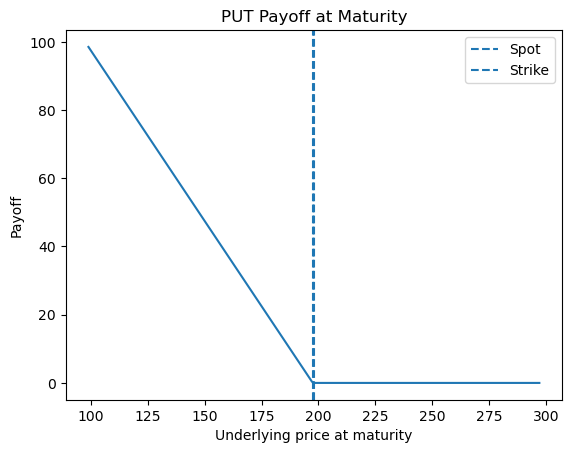

In [55]:
S_grid = np.linspace(0.5 * S0, 1.5 * S0, 300)

if option_type == "call":
    payoff = np.maximum(S_grid - K, 0)
else: #Put
    payoff = np.maximum(K - S_grid, 0)

plt.figure()
plt.plot(S_grid, payoff)
plt.axvline(S0, linestyle="--", label="Spot")
plt.axvline(K, linestyle="--", label="Strike")
plt.title(f"{option_type.upper()} Payoff at Maturity")
plt.xlabel("Underlying price at maturity")
plt.ylabel("Payoff")
plt.legend()
plt.show()

In [56]:
prices, deltas, gammas, vegas, thetas = [], [], [], [], []

for S in S_grid:
    res = bs_price_greeks(S, K, T, r, sigma, q, option_type)
    prices.append(res.price)
    deltas.append(res.delta)
    gammas.append(res.gamma)
    vegas.append(res.vega)
    thetas.append(res.theta)

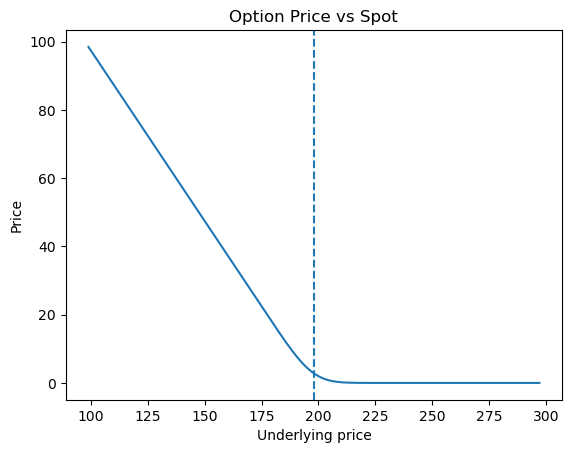

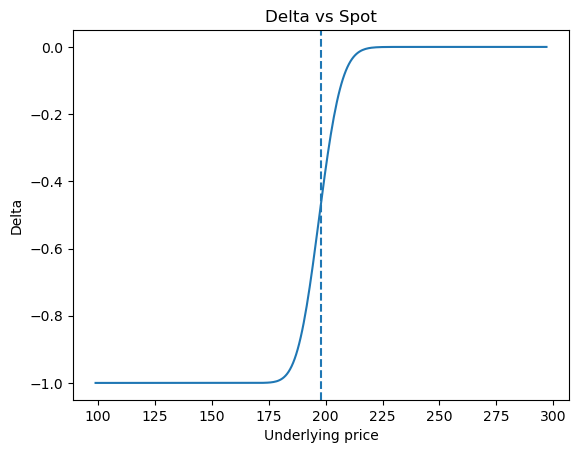

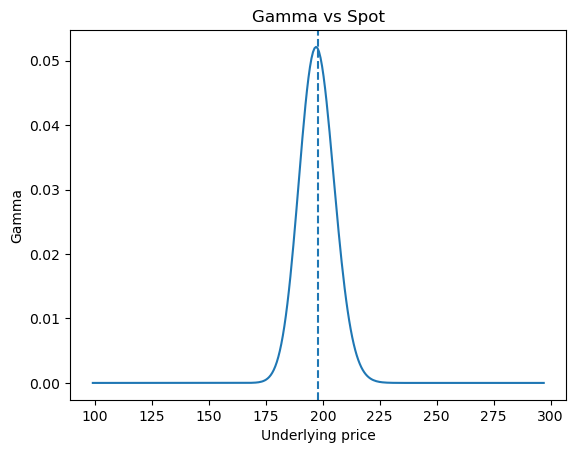

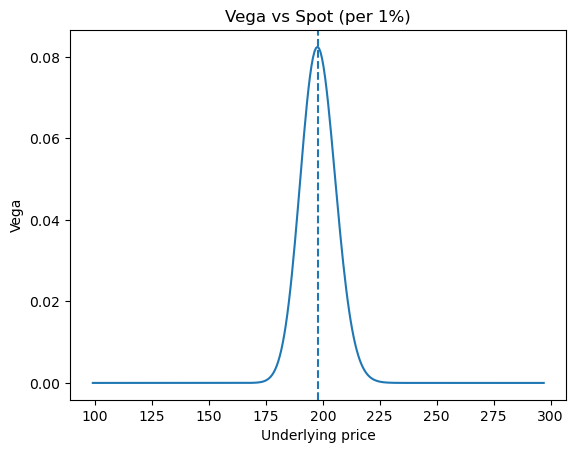

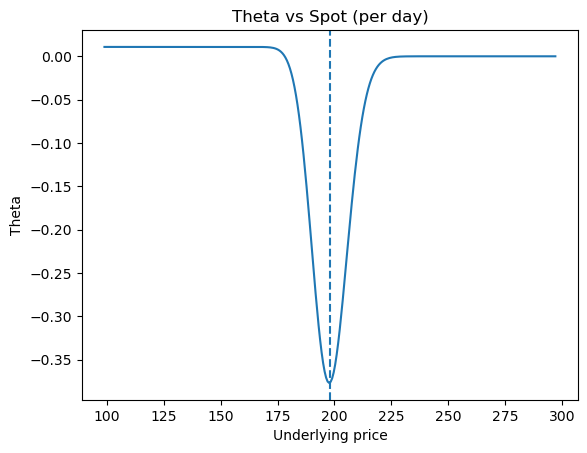

In [57]:
def plot_greek(x, y, title, ylabel):
    plt.figure()
    plt.plot(x, y)
    plt.axvline(S0, linestyle="--")
    plt.title(title)
    plt.xlabel("Underlying price")
    plt.ylabel(ylabel)
    plt.show()

plot_greek(S_grid, prices, "Option Price vs Spot", "Price")
plot_greek(S_grid, deltas, "Delta vs Spot", "Delta")
plot_greek(S_grid, gammas, "Gamma vs Spot", "Gamma")
plot_greek(S_grid, vegas, "Vega vs Spot (per 1%)", "Vega")
plot_greek(S_grid, thetas, "Theta vs Spot (per day)", "Theta")